In [1]:
import qiskit
import numpy as np
import sys
sys.path.insert(0, '../..')
import qoop.core.random_circuit
import qoop.backend.constant
import qoop.core.dag
%load_ext autoreload
%autoreload 2

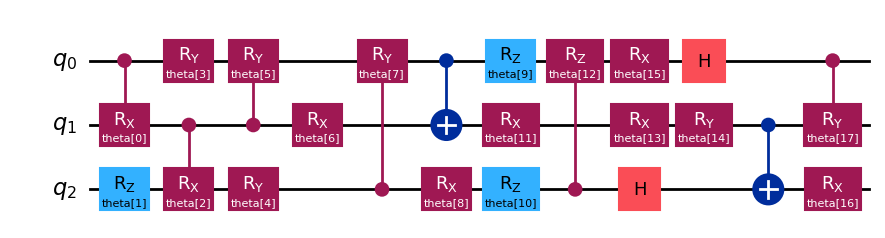

In [2]:
qc = qoop.core.random_circuit.generate_with_pool(3, 10)
qc.draw('mpl')

In [2]:
num_qubits = 3
num_depth = 10
qc = qoop.core.random_circuit.generate_with_pool(num_qubits, num_depth)
dag = qiskit.converters.circuit_to_dag(qc)
dag.draw()

MissingOptionalLibraryError: "The 'graphviz' library is required to use 'dag_drawer'. You can install it with ''brew install graphviz' if on Mac, or by downloding it from their website'."

In [111]:

dag = qiskit.converters.circuit_to_dag(qc)
tinyDAG = qoop.dag.TinyDAG(dag)
tinyDAG.construct()
for i in range(len(tinyDAG.nodes)):
    print(f'Name: {tinyDAG.nodes[i].op_name}, index: {tinyDAG.nodes[i].index}')
    for node in tinyDAG.nodes[i].successor:
        print(node.index)
    print('...')

Name: rx, index: 0
3
...
Name: rz, index: 1
4
...
Name: h, index: 2
5
...
Name: rx, index: 3
6
...
Name: rz, index: 4
8
...
Name: rx, index: 5
7
...
Name: rx, index: 6
...
Name: ry, index: 7
...
Name: ry, index: 8
...


In [120]:
print(qoop.dag.circuit_to_adjacency_matrix(qc))

[[0.     0.     0.     1.2709 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     2.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.2726 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     2.2873 0.    ]
 [0.     0.     0.     0.     0.     0.     1.2738 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.8026 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


In [79]:
name_gate1 = 'crx'
name_gate2 = 'ry'
def gate_distance(name_gate1, name_gate2):
    if name_gate1 == name_gate2:
        return 0
    operation1 = [d for d in qoop.constant.full_operations if any(v == name_gate1 for v in d.values())][0]
    operation2 = [d for d in qoop.constant.full_operations if any(v == name_gate2 for v in d.values())][0]
    i_matrix = qoop.constant.I_gate['operation']().to_matrix()
    operations = [operation1, operation2]
    matrixs = 2*[0]
    max_num_op = 0
    max_num_params = 0
    num_samples = 100000
    distances = []
    for i, operation in enumerate(operations):
        if operation['num_op'] > max_num_op:
            max_num_op = operation['num_op']
        if operation['num_params'] > max_num_params:
            max_num_params = operation['num_params']
    if max_num_params == 0:
        num_samples = 1
    for _ in range(num_samples):   
        params = list(np.random.uniform(low = 0, high = 2*np.pi, size = max_num_params))
        for i, operation in enumerate(operations):
            if operation['num_params'] > 0:
                matrixs[i] = operation['operation'](*params[:operation['num_params']]).to_matrix()
            else:
                matrixs[i] = operation['operation']().to_matrix()
            if operation['num_op'] < max_num_op:
                for j in range(operation['num_op'], max_num_op):
                    matrixs[i] = np.kron(matrixs[i], i_matrix)
        distance = np.linalg.norm(matrixs[0] - matrixs[1])
        distances.append(distance)
    return (np.average(distances))

name_gates = [d['name'] for d in qoop.constant.full_operations]
list_distances = []
for name_gate1 in name_gates:
    for name_gate2 in name_gates:
        list_distances.append({
            'name_gate1': name_gate1, 
            'name_gate2': name_gate2,
            'distance': np.round(gate_distance(name_gate1, name_gate2), 4)
        })